1- Import XRay Images


In [1]:
import os 
import cv2
import numpy as np 
# traitement dataframe
import pandas as pd
# apprentissage automatique
import tensorflow as tf
# permet de faire des graphiques
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_validate


2024-05-14 10:47:18.513294: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 10:47:18.515671: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 10:47:18.518023: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 10:47:18.544821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 10:47:19.294062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2- Class XrayLoader

In [2]:
class XrayLoader:
    def __init__(self, x_train=None, x_train_reshaped= None, y_train=None, x_val=None, x_val_reshaped=None, y_val=None, x_test=None, x_test_reshaped=None, y_test=None):
        self.x_train = x_train
        self.x_train_reshaped = x_train_reshaped 
        self.y_train = y_train
        self.x_val = x_val
        self.x_val_reshaped = x_val_reshaped
        self.y_val = y_val
        self.x_test = x_test
        self.x_test_reshaped = x_test_reshaped
        self.y_test = y_test
        self.data_folder = './XrayDatas/chest_Xray'
        self.image_size = (256,256)
        self.batch_size = 5

    def load_data(self):
        subfolders = ["train","val","test"]
        categories = ["NORMAL","PNEUMONIA"]
        data = {}

        for subfolder in subfolders:
            data[subfolder] = {"x":[],"y":[]}
            for category in categories:
                # pour avoir tous les chemins des 6 dossiers
                folder_path = os.path.join(self.data_folder,subfolder,category)
                # liste de toutes les images
                images_files = os.listdir(folder_path)
                for file_name in images_files:
                    image_path = os.path.join(folder_path,file_name)
                    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    # img = cv2.resize(img,self.image_size)
                    # divide by 255 to normalize images
                    data[subfolder]["x"].append(img/255)
                    data[subfolder]["y"].append(category)
        
        reshaped_coef = self.image_size[0]*self.image_size[0]
        
        self.x_train = np.array(data["train"]["x"])
        self.x_train_reshaped = self.x_train.reshape(-1, reshaped_coef)
        self.y_train = data["train"]["y"]
        self.x_val = np.array(data["val"]["x"])
        self.x_val_reshaped = self.x_val.reshape(-1, reshaped_coef)
        self.y_val = data["val"]["y"]
        self.x_test = np.array(data["test"]["x"])
        self.x_test_reshaped = self.x_test.reshape(-1, reshaped_coef)
        self.y_test = data["test"]["y"]
    
    def load_data_faster(self):
        (self.x_train, self.y_train) = self.make_dataset(self.data_folder+'/train', self.batch_size, self.image_size)
        (self.x_val, self.y_val) = self.make_dataset(self.data_folder+'/val', self.batch_size, self.image_size)
        (self.x_test, self.y_test) = self.make_dataset(self.data_folder+'/test', self.batch_size, self.image_size)

        
    def make_dataset(self, directory, batch_size, image_size):
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        labels='inferred',
        label_mode='int',
        color_mode='grayscale',
        image_size=image_size,
        batch_size=batch_size
        )
        datas = [x for x,_ in dataset]
        labels = [y for _,y in  dataset]
        #Using the np.concatenate to convert datas and labels into single np.array 
        return np.concatenate(datas, axis = 0), np.concatenate(labels, axis = 0)

    def display_image(self,dataset,index):
        if dataset == 'train':
            image = self.x_train[index]
            label = self.y_train[index]
            #crop border of the image
            cropped = image[0:256,5:221]
            
        elif dataset == 'test':
            image = self.x_test[index]
            label = self.y_test[index]
            cropped = image[0:256,5:221]
        else:
            raise ValueError('Invalid dataset. Choose either "train" or "test".')

        plt.imshow(image,cmap="gray")
        plt.title(f'Image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()
        
        plt.imshow(cropped,cmap="gray")
        plt.title(f'Cropped image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()
    
    def display_category_means(self):
        normal_mean = self.calculate_category_mean(self.x_train, self.y_train, "NORMAL")
        pneumonia_mean = self.calculate_category_mean(self.x_train, self.y_train, "PNEUMONIA")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(normal_mean, cmap="gray")
        plt.title("Mean NORMAL Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pneumonia_mean, cmap="gray")
        plt.title("Mean PNEUMONIA Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def calculate_category_mean(images, labels, category):
        images = np.array(images)
        labels = np.array(labels)
        category_images = images[labels == category]
        mean_image = np.mean(category_images, axis=0)
        return mean_image
    
    def display_distribution(self):
        test = ( self.y_test.count("NORMAL"), self.y_test.count("PNEUMONIA") )
        train = ( self.y_train.count("NORMAL"), self.y_train.count("PNEUMONIA") )
        val = ( self.y_val.count("NORMAL"), self.y_val.count("PNEUMONIA") )
        
        # Tracer les graphiques de distribution
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].bar(["NORMAL", "PNEUMONIA"], train)
        ax[0].set_title("Train Distribution")
        ax[1].bar(["NORMAL", "PNEUMONIA"], val)
        ax[1].set_title("Validation Distribution")
        ax[2].bar(["NORMAL", "PNEUMONIA"], test)
        ax[2].set_title("Test Distribution")
        plt.show()
    


In [ ]:
temporary_loader = XrayLoader()
temporary_loader.load_data()
xtrain = temporary_loader.x_train
xtrain_reshaped = temporary_loader.x_train_reshaped
ytrain = temporary_loader.y_train
xtest = temporary_loader.x_test
xtest_reshaped = temporary_loader.x_test_reshaped
ytest = temporary_loader.y_test
xval = temporary_loader.x_val
xval_reshaped = temporary_loader.x_val_reshaped
yval = temporary_loader.y_val

In [ ]:
print(xtrain.shape)
print(xtrain_reshaped.shape)

In [ ]:
xtrain_cropped = xtrain[:,0:256,5:221]
xtrain_cropped_reshaped = xtrain_cropped.reshape(-1, 256*216)
xtest_cropped = xtest[:,0:256,5:221]
xtest_cropped_reshaped = xtest_cropped.reshape(-1, 256*216)

In [ ]:
loader = XrayLoader(x_train=xtrain, x_train_reshaped=xtrain_reshaped, y_train=ytrain, x_val=xval, x_val_reshaped=xval_reshaped, y_val=yval, x_test=xtest, x_test_reshaped=xtest_reshaped, y_test=ytest)

In [ ]:
loader.display_image("train",5100)

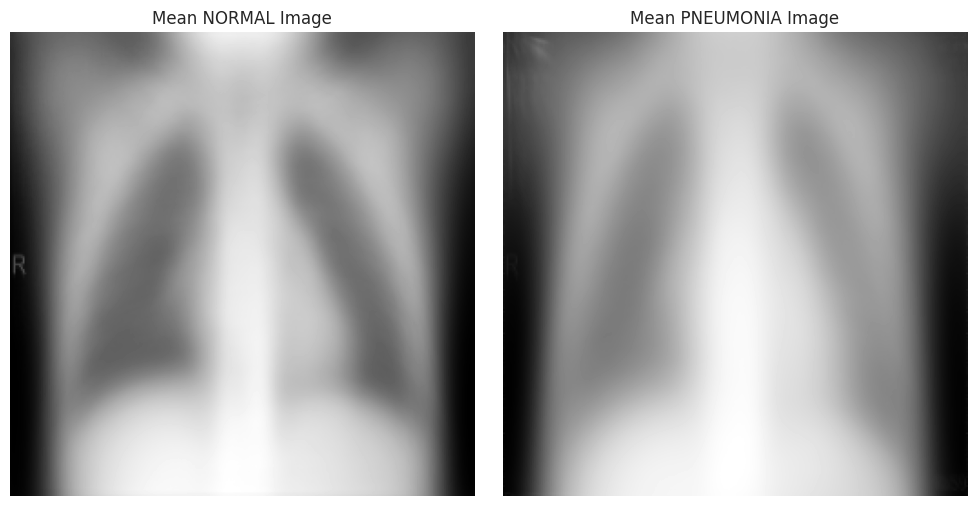

In [7]:
loader.display_category_means()

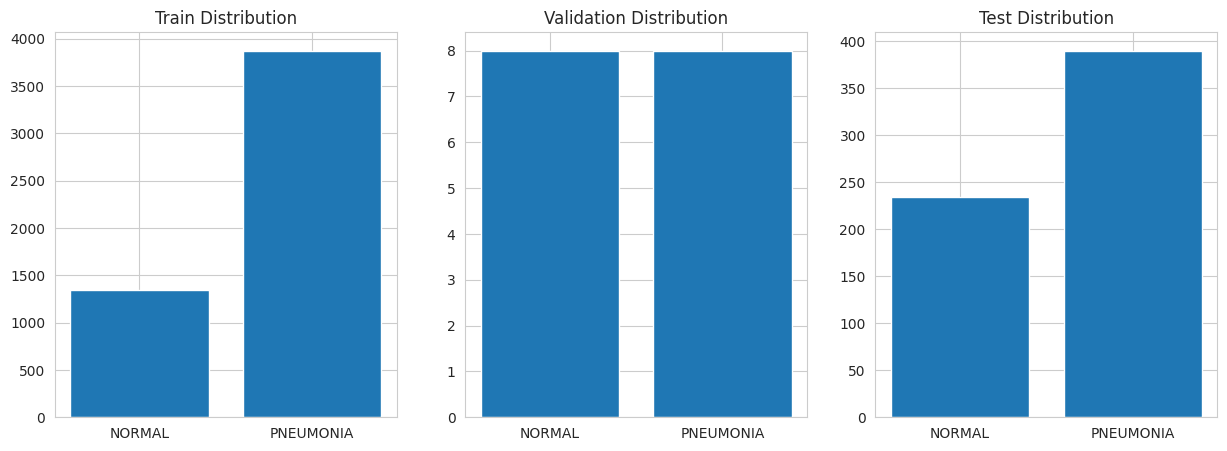

In [8]:
loader.display_distribution()

In [9]:
# modèle KNN proposé dans le bootsrap qui se base sur la moyenne (expliqué dans le recap plus haut)
model = KNeighborsClassifier(n_neighbors=2)
# entraînement du modèle
model.fit(loader.x_train_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(loader.x_test_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)
recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)
precision = precision_score(loader.y_test, y_pred, average='macro')
print("Precision : ", precision)
scores = cross_validate(model, loader.x_test_reshaped, loader.y_test, cv=5, scoring=['accuracy', 'recall_macro', 'precision_macro'])
print("cross validation accuracy : ", scores["test_accuracy"])
print("cross validation recall : ", scores["test_recall_macro"])
print("cross validation precision : ", scores["test_precision_macro"])

Accuracy :  0.7932692307692307
Recall :  0.7346153846153847
Precision :  0.835306553911205
cross validation accuracy :  [0.84       0.808      0.84       0.848      0.87096774]
cross validation recall :  [0.83797054 0.77850518 0.82951446 0.83592471 0.86176143]
cross validation precision :  [0.82829889 0.80441264 0.82951446 0.83888277 0.86176143]


# test avec images cropées

In [10]:
# modèle KNN proposé dans le bootsrap qui se base sur la moyenne (expliqué dans le recap plus haut)
model = KNeighborsClassifier(n_neighbors=2)
# entraînement du modèle
model.fit(xtrain_cropped_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(xtest_cropped_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)
recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)
precision = precision_score(loader.y_test, y_pred, average='macro')
print("Precision : ", precision)
scores = cross_validate(model, xtest_cropped_reshaped, loader.y_test, cv=5, scoring=['accuracy', 'recall_macro', 'precision_macro'])
print("cross validation accuracy : ", scores["test_accuracy"])
print("cross validation recall : ", scores["test_recall_macro"])
print("cross validation precision : ", scores["test_precision_macro"])

Accuracy :  0.7756410256410257
Recall :  0.7076923076923076
Precision :  0.8352316943756632
cross validation accuracy :  [0.832      0.848      0.792      0.848      0.80645161]
cross validation recall :  [0.82733224 0.82746863 0.78682488 0.84015276 0.78818283]
cross validation precision :  [0.82       0.84437751 0.77861685 0.83739177 0.79375   ]


In [11]:
# modèle déjà prêt de scikit learn qui utilise plusieurs arbres de décisions où chaque noeud est un else-if
model = RandomForestClassifier()
# entraînement du modèle
model.fit(loader.x_train_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(loader.x_test_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)
recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)
precision = precision_score(loader.y_test, y_pred, average='macro')
print("Precision : ", precision)
scores = cross_validate(model, loader.x_test_reshaped, loader.y_test, cv=5, scoring=['accuracy', 'recall_macro', 'precision_macro'])
print("cross validation accuracy : ", scores["test_accuracy"])
print("cross validation recall : ", scores["test_recall_macro"])
print("cross validation precision : ", scores["test_precision_macro"])

Accuracy :  0.7580128205128205
Recall :  0.6799145299145299
Precision :  0.8448283104063845
cross validation accuracy :  [0.888      0.912      0.88       0.904      0.83870968]
cross validation recall :  [0.87220404 0.90411893 0.85310966 0.88079651 0.82274247]
cross validation precision :  [0.88698242 0.90767749 0.8915608  0.91621944 0.82897727]


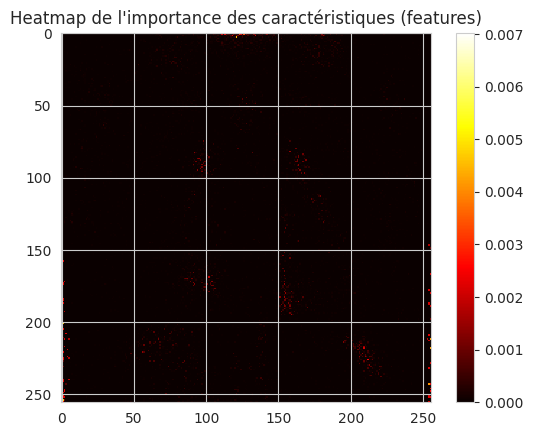

In [12]:
## Heatmap pour RandomForest

# Obtenir l'importance des caractéristiques
feature_importances = model.feature_importances_

# Reshape l'importance des caractéristiques pour correspondre à la forme de l'image originale
importance_map = feature_importances.reshape(loader.image_size)

# Afficher la heatmap
plt.imshow(importance_map, cmap='hot', interpolation='nearest')
plt.title('Heatmap de l\'importance des caractéristiques (features)')
plt.colorbar()
plt.show()

# test avec images cropées

In [13]:
# modèle déjà prêt de scikit learn qui utilise plusieurs arbres de décisions où chaque noeud est un else-if
model = RandomForestClassifier()
# entraînement du modèle
model.fit(xtrain_cropped_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(xtest_cropped_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)
recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)
precision = precision_score(loader.y_test, y_pred, average='macro')
print("Precision : ", precision)
scores = cross_validate(model, xtest_cropped_reshaped, loader.y_test, cv=5, scoring=['accuracy', 'recall_macro', 'precision_macro'])
print("cross validation accuracy : ", scores["test_accuracy"])
print("cross validation recall : ", scores["test_recall_macro"])
print("cross validation precision : ", scores["test_precision_macro"])

Accuracy :  0.7612179487179487
Recall :  0.6841880341880342
Precision :  0.846555883141249
cross validation accuracy :  [0.888      0.888      0.896      0.88       0.85483871]
cross validation recall :  [0.87643208 0.87220404 0.87861429 0.84888161 0.8400223 ]
cross validation precision :  [0.88333333 0.88698242 0.89816408 0.89918851 0.84659091]


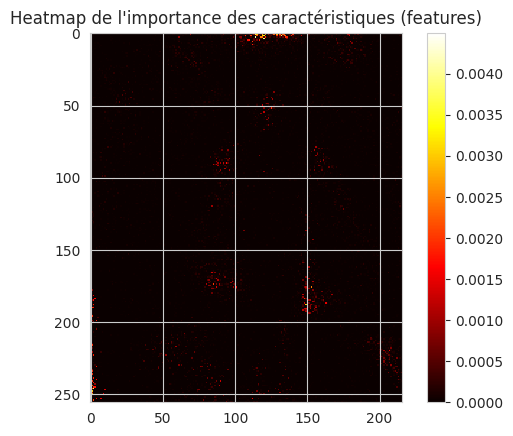

In [14]:
## Heatmap pour RandomForest

# Obtenir l'importance des caractéristiques
feature_importances = model.feature_importances_

# Reshape l'importance des caractéristiques pour correspondre à la forme de l'image originale
importance_map = feature_importances.reshape((256, 216))

# Afficher la heatmap
plt.imshow(importance_map, cmap='hot', interpolation='nearest')
plt.title('Heatmap de l\'importance des caractéristiques (features)')
plt.colorbar()
plt.show()